# UIUC Wind Power with Echo State Networks

This notebook uses an Echo State Network(ESN) (from ``pyESN``) to predict
the electricity produced by the Railsplitter Wind farm.
All predictions in this notebook are optimized for 72 hour predictions. The
parameters will not generalize well to other prediction lengths because they
are optimized by looking at the mean squared error over the entire prediction
window.
In the future, the specific reactor design will motivate the size of the prediction
window.


The following items are included:
1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

### 1. Initial Demonstration

In [1]:
# import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from pyESN.pyESN import ESN

In [2]:
# import demand data
dataframe = pd.read_csv("data/railsplitter_data.csv", usecols=['Time','MWh'])
windpower = np.array(dataframe.MWh).astype('float64')

# normalize
norm = np.linalg.norm(windpower)
windpower_norm = windpower/norm

In [3]:
params = {'n_reservoir':1000, 
          'sparsity':0.1, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':None, 
          'trainlen':8000}

In [5]:
futureTotal = params['future']
time_range = np.array(dataframe.Time)
hour_range = np.arange(0, len(time_range), 1)

In [7]:
tic = time.perf_counter()

init_pred = esn_prediction(windpower_norm, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 18.81 seconds
This simulation took 0.31 minutes


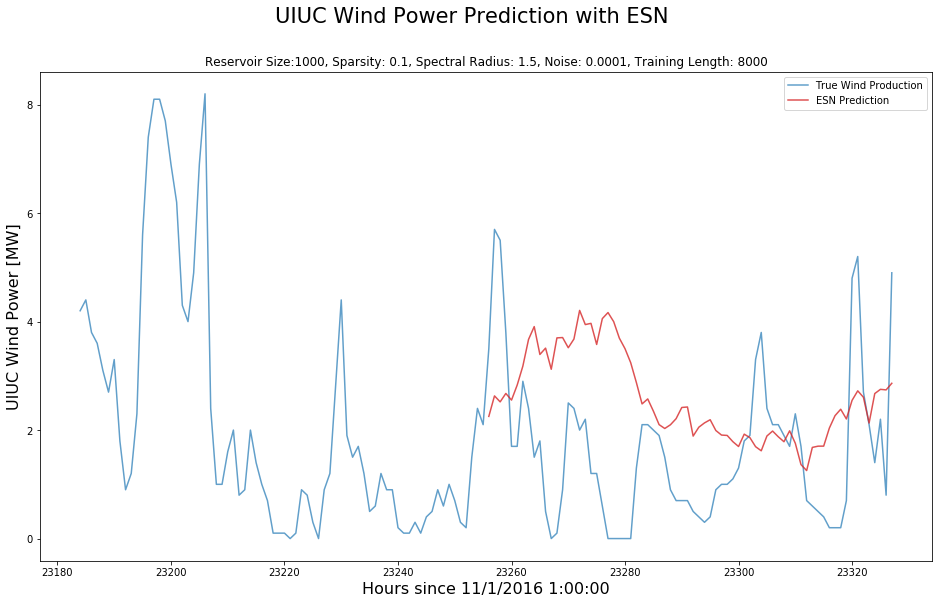

In [8]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Wind Power [MW]", fontsize=16)
plt.xlabel("Hours since 11/1/2016 1:00:00", fontsize=16)

# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*init_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

Optimizing over ['rho', 'noise']:
rho = 0.5, noise = 0.0001, MSE=0.00345757911145509
rho = 0.5, noise = 0.0003, MSE=0.003588244223615075
rho = 0.5, noise = 0.0007, MSE=0.003653485667805578
rho = 0.5, noise = 0.001, MSE=0.0036677974889118914
rho = 0.5, noise = 0.003, MSE=0.003699610238351574
rho = 0.5, noise = 0.005, MSE=0.003708897237367963
rho = 0.5, noise = 0.007, MSE=0.003723675586159055
rho = 0.5, noise = 0.01, MSE=0.0037562797445930556
rho = 0.7, noise = 0.0001, MSE=0.0033486783517962626
rho = 0.7, noise = 0.0003, MSE=0.003467691950508525
rho = 0.7, noise = 0.0007, MSE=0.003566933118606054
rho = 0.7, noise = 0.001, MSE=0.0036049659258708963
rho = 0.7, noise = 0.003, MSE=0.0036734653703619793
rho = 0.7, noise = 0.005, MSE=0.0036873509263728355
rho = 0.7, noise = 0.007, MSE=0.0036975814976600726
rho = 0.7, noise = 0.01, MSE=0.0037174255426993563
rho = 0.9, noise = 0.0001, MSE=0.0032131604127119792
rho = 0.9, noise = 0.0003, MSE=0.003255884173426088
rho = 0.9, noise = 0.0007, MSE=0.0

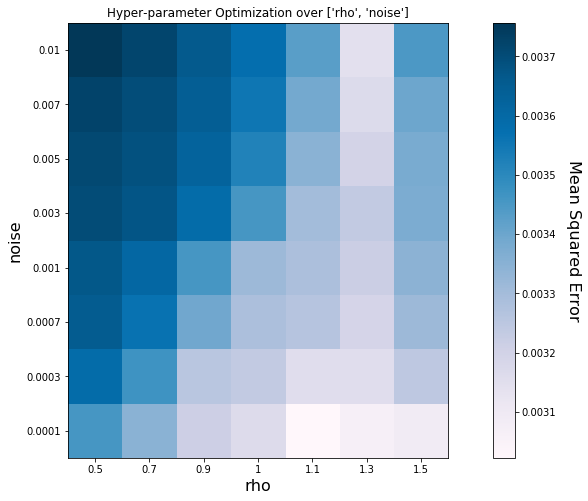

In [10]:
tic = time.perf_counter()
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radiusxnoise_loss = grid_optimizer(windpower_norm,
                      params,
                      args=['rho', 'noise'],
                      xset=radius_set,
                      yset=noise_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

In [11]:
opt_radius, opt_noise = optimal_values(radiusxnoise_loss, radius_set, noise_set)
params['rho'] = opt_radius
params['noise'] = opt_noise
print(f'The optimal set is:\nspectrum radius = {opt_radius} \nnoise = {opt_noise}')

The optimal set is:
spectrum radius = 1.1 
noise = 0.0001


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

Optimizing over ['n_reservoir', 'sparsity']:
n_reservoir = 600, sparsity = 0.005, MSE=0.0034712361970967807
n_reservoir = 600, sparsity = 0.01, MSE=0.003571771319603889
n_reservoir = 600, sparsity = 0.03, MSE=0.0033864065541535514
n_reservoir = 600, sparsity = 0.05, MSE=0.0033273526986038813
n_reservoir = 600, sparsity = 0.1, MSE=0.003170292878327415
n_reservoir = 600, sparsity = 0.15, MSE=0.003133029316746744
n_reservoir = 600, sparsity = 0.2, MSE=0.0028028603383786943
n_reservoir = 800, sparsity = 0.005, MSE=0.003707490894939874
n_reservoir = 800, sparsity = 0.01, MSE=0.0038260533024027064
n_reservoir = 800, sparsity = 0.03, MSE=0.003668023465342468
n_reservoir = 800, sparsity = 0.05, MSE=0.003427794086136492
n_reservoir = 800, sparsity = 0.1, MSE=0.0037474155585499745
n_reservoir = 800, sparsity = 0.15, MSE=0.003470759704024816
n_reservoir = 800, sparsity = 0.2, MSE=0.0032641574968378033
n_reservoir = 1000, sparsity = 0.005, MSE=0.003198761033937804
n_reservoir = 1000, sparsity = 0.

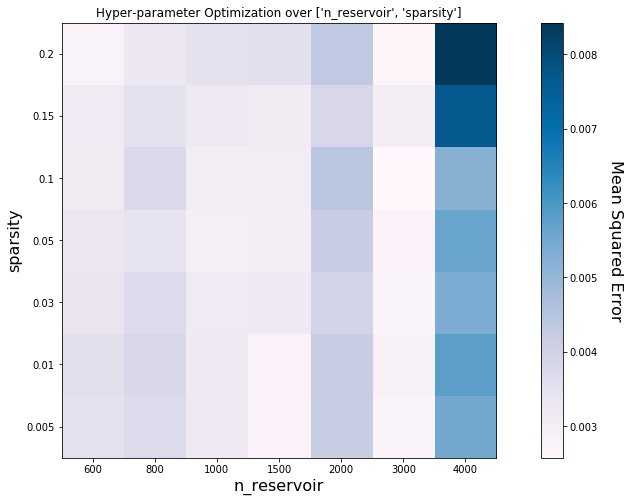

In [12]:
tic = time.perf_counter()
reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

sizexsparsity_loss = grid_optimizer(windpower_norm,
                      params,
                      args=['n_reservoir', 'sparsity'],
                      xset=reservoir_set,
                      yset=sparsity_set,
                      verbose=True,
                      visualize=True)
        
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02} seconds.")
print(f"This simulation took {elapsed/60:0.02} minutes.")

In [13]:
opt_size, opt_sparsity = optimal_values(sizexsparsity_loss, reservoir_set, sparsity_set)
params['n_reservoir'] = opt_size
params['sparsity'] = opt_sparsity
print(f'The optimal set is:\nreservoir size = {opt_size} \nsparsity = {opt_sparsity}')

The optimal set is:
reservoir size = 3000 
sparsity = 0.1


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

In [14]:
tic = time.perf_counter()
trainingLengths = np.arange(4000,22000,300)
trainlen_loss = grid_optimizer(windpower_norm,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

Optimizing over ['trainlen']:
trainlen = 4000, MSE=0.008986576792881305
trainlen = 4300, MSE=0.010601884360045282
trainlen = 4600, MSE=0.005586137339274948
trainlen = 4900, MSE=0.006118724631967296
trainlen = 5200, MSE=0.007322472139881491
trainlen = 5500, MSE=0.0066018305504245015
trainlen = 5800, MSE=0.005143183067632208
trainlen = 6100, MSE=0.006148515699978655
trainlen = 6400, MSE=0.004373016024791068
trainlen = 6700, MSE=0.0051785132125886585
trainlen = 7000, MSE=0.004160500452209016
trainlen = 7300, MSE=0.0024463198482670193
trainlen = 7600, MSE=0.004865132112369033
trainlen = 7900, MSE=0.003978396923888001
trainlen = 8200, MSE=0.0035358258226194216
trainlen = 8500, MSE=0.0063042540130237345
trainlen = 8800, MSE=0.0030951310298311494
trainlen = 9100, MSE=0.003987000017196681
trainlen = 9400, MSE=0.004450189143562143
trainlen = 9700, MSE=0.004054330270139919
trainlen = 10000, MSE=0.00230946697883563
trainlen = 10300, MSE=0.003386388603633578
trainlen = 10600, MSE=0.004044591952937

IndexError: index 23256 is out of bounds for axis 0 with size 23256

In [15]:
# The value of l_opt is 10,000. 
# The previous simulation tried a training length longer than the available data.
# Thus, threw an error. The simulation is too long to warrant a rerun at this time.
minloss = np.min(trainlen_loss)
index_min = np.where(trainlen_loss == minloss)
l_opt = trainingLengths[index_min][0]
params['trainlen'] = l_opt
print(f"Training length with minimum error was: {l_opt}")

NameError: name 'trainlen_loss' is not defined

In [16]:
params['trainlen'] = 10000  # delete this block in the future.

### 5. Final Optimized ESN

In [17]:
tic = time.perf_counter()

opt_pred = esn_prediction(windpower_norm, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 60.59 seconds
This simulation took 1.01 minutes


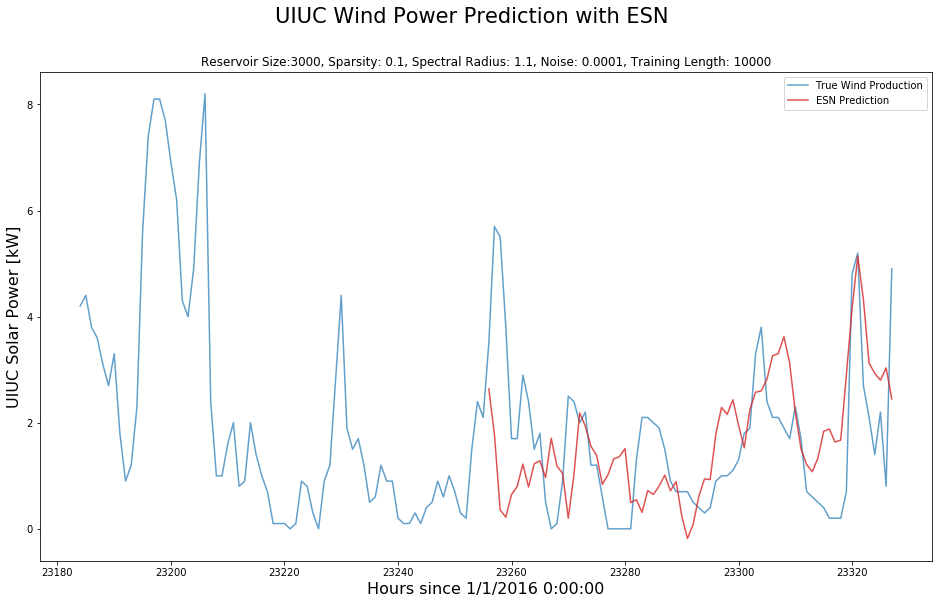

In [18]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Solar Power [kW]", fontsize=16)
plt.xlabel("Hours since 1/1/2016 0:00:00", fontsize=16)

# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*opt_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()